Based on dcgan MNIST tutorial. Added elements from TensorFlow Privacy. Unable to use ledger yet.


Lulu

### 13/08/2020

## Setup

In [ ]:
!pip install tensorflow
!pip install tensorflow_privacy
import tensorflow as tf

from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamGaussianOptimizer as dp_optimizer

from tensorflow_privacy.privacy.analysis import privacy_ledger, privacy_ledger_test, compute_dp_sgd_privacy
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp, compute_rdp_from_ledger, get_privacy_spent

!pip install imageio # To generate GIFs
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6cfuxgt7
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-6cfuxgt7
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.03dfbe1643a219d62da55ea4d499aa638ecc03c7a_-cp36-none-any.whl size=132741 sha256=729b37f92107af734b1f90ec31493f3b7db8a071faf87ba7eada081095f70734
  Stored in directory: /tmp/pip-ephem-wheel-cache-kwc57jki/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [ ]:
# Load and prepare dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Batch and shuffle the data
def make_train_dataset():
  train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(n).batch(batch_size)
  print('Loaded data and created training set')
  return train_dataset

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    print('Made generator model')
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    print('Made discriminator model')
    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def make_ledgers():
  generator_ledger = privacy_ledger.PrivacyLedger(
            population_size=n,
            selection_probability=(batch_size / n))
  discriminator_ledger = privacy_ledger.PrivacyLedger(
            population_size=n,
            selection_probability=(batch_size / n))
  print('Made generator and discriminator ledgers')
  return generator_ledger, discriminator_ledger
  
def make_optimizers():
  dp_generator_optimizer = dp_optimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    ledger=generator_ledger,
    learning_rate=learning_rate)

  dp_discriminator_optimizer = dp_optimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    ledger=discriminator_ledger,
    learning_rate=learning_rate)
  
  print('Made DP generator and discriminator optimizers')
  return dp_generator_optimizer, dp_discriminator_optimizer

In [ ]:
### Training loop

@tf.function
def dp_train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = dp_generator(noise, training=True)

      real_output = dp_discriminator(images, training=True)
      fake_output = dp_discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, dp_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dp_discriminator.trainable_variables)

    dp_generator_optimizer.apply_gradients(zip(gradients_of_generator, dp_generator.trainable_variables))
    dp_discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dp_discriminator.trainable_variables))


def dp_train(dataset, epochs):
  print('Training has begun')
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      dp_train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    dp_generate_and_save_images(dp_generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  dp_generate_and_save_images(dp_generator,
                           epochs,
                           seed)
  print('Training complete')
  
def dp_generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('dp_image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Running the GAN:

In [ ]:
n=60000
epochs = 1
batch_size = 250
l2_norm_clip = 1
noise_multiplier = 0.001
num_microbatches = 250
learning_rate = 1e-4

noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [ ]:
train_dataset = make_train_dataset()
dp_generator = make_generator_model()
dp_discriminator = make_discriminator_model()
generator_ledger, discriminator_ledger = make_ledgers()
dp_generator_optimizer, dp_discriminator_optimizer = make_optimizers()

Loaded data and created training set
Made generator model
Made discriminator model
Made generator and discriminator ledgers
Made DP generator and discriminator optimizers


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(dp_generator_optimizer=dp_generator_optimizer,
                                 dp_discriminator_optimizer=dp_discriminator_optimizer,
                                 dp_generator=dp_generator,
                                 dp_discriminator= dp_discriminator)

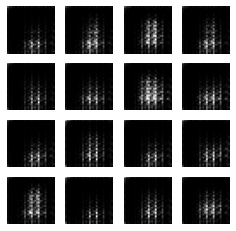

Training complete


In [ ]:
dp_train(train_dataset, epochs=epochs)


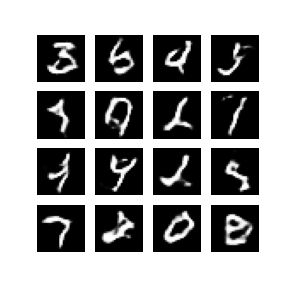

In [ ]:
dp_anim_file = 'dp_dcgan_2.gif'

with imageio.get_writer(dp_anim_file, mode='I') as writer:
  filenames = glob.glob('dp_image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

embed.embed_file(dp_anim_file)

## Privacy Analysis

In [ ]:
## Estimate Privacy Budget
# Can be done before training to choose hyperparameters

# This function was taken from compute_dp_sgd_anaysis_lib and modified
def apply_dp_sgd_analysis(noise_multiplier, target_delta, epochs, batch_size, n):
  """Compute and print results of DP-SGD analysis."""
  steps = int(math.ceil(epochs*n/batch_size))
  orders = np.linspace(1.00000001, 1.000002)
  q = batch_size / n
  rdp = compute_rdp(q, noise_multiplier, steps, orders)

  eps, _, opt_order = get_privacy_spent(orders=orders, rdp=rdp, target_delta=target_delta)

  # print('DP-SGD with sampling rate = {:.3g}% and noise_multiplier = {} iterated'
        # ' over {} steps satisfies'.format(100 * q, sigma, steps), end=' ')
  print('differential privacy with eps = {:.3g} and delta = {}.'.format(
      eps, target_delta))
  print('The optimal RDP order is {}.'.format(opt_order))

  if opt_order == max(orders) or opt_order == min(orders):
    print('The privacy estimate is likely to be improved by expanding '
          'the set of orders.')

  return eps, opt_order

In [ ]:
apply_dp_sgd_analysis(noise_multiplier, target_delta=0.1, epochs=5000, batch_size=batch_size, n=n)

differential privacy with eps = 2.58e+09 and delta = 0.1.
The optimal RDP order is 1.0000000506122448.


(2577227673.0125403, 1.0000000506122448)

In [ ]:
from tensorflow_privacy.privacy.analysis import privacy_ledger_test

In [ ]:
test = PrivacyLedgerTest(tf.test.TestCase)
test.test_fail_on_probability_zero()

NameError: ignored